# TD2 : Classification d'image

Dans ce TD nous verrons...

In [ ]:
%%capture
# Commençons par charger un modèle pré-entrainé, si vous lancez cette commande pour la première fois dans pytorch
# le téléchargement peut être un peu long
import torch
import torchvision
vgg16_model = torchvision.models.vgg16(pretrained=True)

# Nous n'allons pas entrainer de modèle dans ce TD. Voilà pourquoi il est important de mettre votre modèle en
# mode évaluation
vgg16_model.eval()

Image Net est une collection de 14 millions images couvrant 1000 catégories d'objets ou d'animaux différents. Cette base de donnée sert de référence pour pré-entrainer des modèles en vision par ordinateur. Un modèle entrainé sur image net apprendra donc à différencier des objets de l'une de ces catégories. 

Mais mille témoignages ne valent pas un regard, testons ensemble.

Tout d'abord, récupérons des fonctions pré-définies pour charger et faire apparaître une image

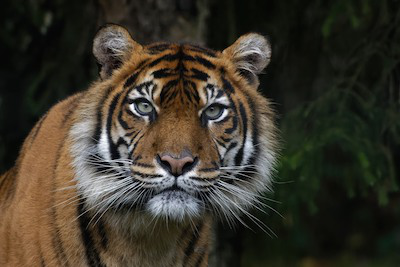

In [2]:
from tools import load_image_in_vgg_format, show_image_from_path
show_image_from_path('isha.jpg')

À tout moment dans le TD vous pourrez ainsi visualiser des images en appelant show_image_from_path(). 
Essayez par exemple avec 'requin_blanc.jpg'

In [ ]:
# Votre code ici : afficher 'requin_blanc.jpg'

La fonction load_image_in_vgg_format permet de charger une image et de la mettre dans un format directement utilisable par le réseau VGG. Regardez l'exemple ci-dessous:

In [ ]:
x = load_image_in_vgg_format('isha.jpg')
print(x.size())

# Que remarquez vous sur la dimension de X ?

Le vecteur x a le format suivant: taille du batch x Nombre de canaux x largeur x hauteur.

Ici on n'a chargé qu'une image donc taille du batch =1. De plus il s'aigit d'une image RVB donc Nombre de canaux =3.
**Nous parlerons à plus bas de ce format NxCxLxH.**

Regardez à présent les valeurs du tensor x.

In [ ]:
print(x)

Pour un meilleur apperçu de ce qui ce passe, vous pouvez jeter un oeil à load_image_in_vgg_format dans tools/tools.py

In [ ]:
# À présent appliquons le model à notre image
vgg_output = vgg16_model(x)

# Regardez un peu les valeurs de vgg_output
print(vgg_output)
print(vgg_output.size())

Il s'agit de 1000 scores de sortie, un pour chaque catégorie possible dans Image Net. Ce score en question peut prendre n'importe quelle valeur, positive ou non. **La catégorie avec le score le plus haut correspond à la prédiction du modèle.**

In [ ]:
# Mais de quel score et quelle catégorie s'agit-il ?
print(vgg_output.max())
print(vgg_output.argmax())

Voici donc deux valeurs qui ne servent pas à grand chose: que veut dire ce score ?
À quelle cateégorie correspond ce nombre ?

Pour le score tout d'abord. Afin de transformer le score de sortie d'un réseau de neurones en une estimation de
certiture, on calcule généralement un softmax:

In [ ]:
# On calcule l'exponentielle terme à terme de la sortie
exp_vgg_output = torch.exp(vgg_output)

# On normalise le résultat de manière à ce que la somme des scores sur toutes les catégories valent 1.
softmax_vgg = exp_vgg_output / exp_vgg_output.sum(dim=1, keepdim=True)

# Regardons à présent le score de probabilité de la meilleure prédiction
print(softmax_vgg.max())

In [ ]:
# Pytorch possède un module permettant de faire cette opération
pytorch_softmax = torch.nn.functional.softmax(vgg_output, dim=1)

# Différence relative entre les deux méthodes
# Vous remarquerez que le résultat n'est pas 0 mais un nombre très proche de 0 (différences d'arrondi)
print(torch.norm(softmax_vgg - pytorch_softmax) / torch.norm(pytorch_softmax))

Pour l'index, regardez dans tools/image_net_2_human.txt pour regarder à quel catégorie correspond la prédiction

## Exercice 1:
Écrivez une fonction pred_vgg qui étant donné une image dans le bon format, renvoie la certitude de la prédiction telle que définie plus haut ainsi que l'index de la catégorie correspondante.

Testez cette fonction avec les images 'isha.jpg', 'requin_blanc.jpg' 

In [ ]:
def run_vgg(image):
    r"""
    Applique le réseau vgg16_model à l'image d'entrée en renvoie le score ainsi que la certitude de la prédiction
    correspondante.
    Argument:
        image: un tenseur de taille 1 x 3 x 224 x 224
    Renvoie:
        index, certitude où
        index (int): est l'index de la catégorie de la prédiction vgg associée
        certitude (float): est la valeur de certitude (calculée avec softmax) correspondant à cette même prédiction
    """
    # Votre code ici !!!
    return index, certitude



In [ ]:
# Testez votre code ici
image_input = load_image_in_vgg_format('isha.jpg')
index, certitude = run_vgg(image_input)

Une fonction de tools permet d'interpréter directement le vecteur résultat de vgg16: il s'agit de Image_net_label_matcher. Comparer les résultats de run_vgg avec les prédictions de Image_net_label_matcher

In [ ]:
from tools import Image_net_label_matcher
image_tensor = load_image_in_vgg_format('isha.jpg')
vgg_output = vgg16_model(image_tensor)
show_image_from_path('isha.jpg')
print(Image_net_label_matcher(vgg_output))

## Mais pourquoi ce format NxCxLxH ?

Pourquoi raisonne-t-on en batchs ? C'est tout simplement parce qu'un réseau de neurones travaille normalement avec plusieurs images à la fois. Regardez l'exemple ci-dessous

In [ ]:
# Tout d'abord chargeons trois images différentes
image_0 = load_image_in_vgg_format('manul.jpg')
image_1 = load_image_in_vgg_format('isha.jpg')
image_2 = load_image_in_vgg_format('requin_blanc.jpg')

# Chaque image a le format suivant : 1 x 3 x 224 x 224
# La fonction torch.cat permet de concatener plusieurs vecteurs en un seul
batch = torch.cat([image_0, image_1, image_2], dim=0)

# Ainsi nous aurons:
# batch.size() = 3 x 3 x 224 x 224
# batch[0] = image_0
# batch[1] = image_1
# batch[2] = image_2

# Lançons à présent vgg sur le batch
output_batch = vgg16_model(batch)

# Que remarquez vous sur la taille du batch de sortie ?
print(output_batch.size())

La fonction Image_net_label_matcher marche sur des batchs de plusieurs images. Regardez l'exemple ci dessous:

In [ ]:
print(Image_net_label_matcher(output_batch))

## Exercice 2:

Définissez une fonction rnn_vgg_on_batch qui prend en entrée un batch d'images au format N x C x L x H et renvoie deux vecteurs index et predictions de taille N tels que, pour tout n entre 0 et N-1:

- index[n] est l'index de la prédiction correspondant à la n-ième image
- predictions[n] est le score de la prédiction correspondant à la n-ième image

Indice: si vous ajoutez l'argument dim dans l'operation max() alors pytorch calculera à la fois la valeur maximum maximum et l'index de la valeur maximum selon la dimension donnée.

Exemple:

In [ ]:
x = torch.randn(2,3, 4)
max_x_dim1, index_max_x_dim1 = x.max(dim=1)
print(x)
print(max_x_dim1.size())

# max_x_dim1[i, k] = max_j(x[i, j, k])
# index_max_x_dim1[i, k] = argmax_j(x[i, j, k])

# Exemple
# Affiche x[0, i, 2] pour i entre 0 et 3
print("x:", x[0, :, 2])

print("max_x", max_x_dim1[0, 2])
print("argmax_x", index_max_x_dim1[0, 2])

In [ ]:
def run_vgg_in_batch(image_batch):
    r"""
    Applique le réseau vgg16_model au batch d'images d'entréę en renvoie les scores ainsi que les certitudes
    des prédictions correspondantes.
    Argument:
        image: un tenseur de taille N x 3 x 224 x 224
    Renvoie:
        index (torch.tensor): tensor des index des catégories des prédictions vgg associées 
                            au batch image_batch. Il doit être de taille N. 
        certitude (torch.tensor): valeur des certitudes (calculées avec softmax) correspondant 
                                  à ces même prédictions. Ce tensor doit être de taille N
    """
    # Votre code ici !!!
    return index, certitude

In [ ]:
# Testez votre code ici:
image_0 = load_image_in_vgg_format('manul.jpg')
image_1 = load_image_in_vgg_format('isha.jpg')
image_2 = load_image_in_vgg_format('requin_blanc.jpg')
image_batch = torch.cat([image_0, image_1, image_2], dim=0)
index, certitude = run_vgg_in_batch(image_batch)

## Exercice 3: 
À présent allons plus loin, un réseau peut hésiter. Ne cherchons plus le score de la prédiction la plus probable, mais celui des k prédictions les plus probables (k > 1).

Définissez une fonction extrait_les_k_meilleurs qui étant donné le vector vgg_output calculé avec vgg et un entier k, estime les k prédictions les plus probables avec leurs scores respectifs.

In [ ]:
def get_k_best_predictions(vgg_output, k):
    r"""
    Arguments
    1) vgg_output : un batch de taille N x 1000 où N est le nombre d'images dans le batch
    2) k (int): le nombre de prédictions aà trouver
    
    Renvoie:
    index, scores
    index (torch.tensor): un tensor de taille N x k tel que index[n][k] soit l'index de la k-eme prediction pour
                          la n-eme image
    score (torch.tensor): un tensor de taille N x k tel que score[n][k] soit le score de la k-eme prediction pour
                          la n-eme image
    """
    # Votre code ici
    return index, scores

In [ ]:
# Testez votre code ici:
image_0 = load_image_in_vgg_format('manul.jpg')
image_1 = load_image_in_vgg_format('isha.jpg')
image_2 = load_image_in_vgg_format('requin_blanc.jpg')
image_batch = torch.cat([image_0, image_1, image_2], dim=0)
index, certitude = get_k_best_predictions(image_batch)